# Autoencoder Assignment

## Guidance:

1.   Run the cells only where you see RUN as a heading, only the extracted fetaures 
(from the encoded layer) and trained model (to extract features from the query image) will be loaded and you can upload a query image and evaluate my model performace.

2.   If you chose to run the whole work, start from the beginning and exceute run all cells, it takes a while to load and prepare the data, to train the AutoEncoder and extrcating the features.







In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
import os
import PIL
import PIL.Image

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten,GlobalAveragePooling2D
from keras.utils.data_utils import get_file
from keras import optimizers, losses
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D,GlobalMaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array

In [ ]:
import cv2
import random
from glob import glob

In [ ]:
from tqdm.notebook import tqdm
import pickle

In [ ]:
!pip install Annoy

     |████████████████████████████████| 645kB 9.1MB/s 
  Created wheel for Annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297334 sha256=1890990820b12aaf228c1b60c5cc64b5ef19ad328dc870356a87ceddb0e04d54
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built Annoy


In [ ]:
from numpy.linalg import norm
import time
from tensorflow.keras.preprocessing import image
from annoy import AnnoyIndex

# RUN

In [ ]:
#Drive Credentials

import zipfile
from google.colab import drive

drive.mount('/content/drive/')
%cd drive/My\ Drive/image_search

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/image_search


In [ ]:
#data_dir = pathlib.Path('/content/drive/My Drive/image_search/dataset')

## **RUN**

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/image_search/dataset')

In [ ]:
data_dir

PosixPath('/content/drive/My Drive/image_search/dataset')

In [ ]:
# Number of Images in the dataset
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

4738


In [ ]:
# Creating the dataset for training

In [ ]:
# Iterating the dataset directory resizing the images to (256,256)
# and adding each processed image to to a list data
data = []
i = 0
for filename in tqdm(os.listdir('dataset')):
    if filename.endswith(".jpg"):
        path = (os.path.join('dataset/', filename))
        image = load_img(path, target_size=(256, 256, 3))
        image = img_to_array(image)
        data.append(image/255.0)
        i += 1
    if i == 3000:
        break

In [ ]:
# Converting the list to an array
data = np.array(data)

In [ ]:
data.shape

(3000, 256, 256, 3)

In [ ]:
#Saving the 256*256 array in a pickle file

with open('data256.pkl','wb') as f:
    pickle.dump(data, f)

In [ ]:
import pickle
data = pickle.load(open("data256.pkl","rb"))
data.shape

(3000, 256, 256, 3)

In [ ]:
#Splitting the data array in to 70% train and 30 % test data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
print(X_train.shape)

(2400, 256, 256, 3)


In [ ]:

# Autoencoder model
print('Create the autoencoder model')

# Encoder #
input_img = Input(shape=(256, 256, 3)) # input image shape -> width = height = 128, no.of color channels = 3
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# Decoder #
x = UpSampling2D((2,2))(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# create the autoencoder model #
autoencoder = Model(input_img, decoded)

# Uses Stochastic gradient descent optimizer
sgd = optimizers.Adam(lr=0.01, clipnorm=1.)

# Loss = Mean Squared Error
autoencoder.compile(optimizer='adam', loss=losses.mean_squared_error)
autoencoder.summary()
print('Autoencoder compilation done')



Create the autoencoder model
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
encoder (MaxPooling2D)   

In [ ]:
# Our encoded layer dimensions are 32*32*128

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=30,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/30
75/75 [==============================] - 18s 244ms/step - loss: 0.0208 - val_loss: 0.0097
Epoch 2/30
75/75 [==============================] - 18s 242ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 3/30
75/75 [==============================] - 18s 246ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 4/30
75/75 [==============================] - 19s 252ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/30
75/75 [==============================] - 19s 255ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 6/30
75/75 [==============================] - 19s 251ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/30
75/75 [==============================] - 19s 251ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 8/30
75/75 [==============================] - 19s 251ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 9/30
75/75 [==============================] - 19s 253ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/30
75/75 [==============================] - 19s 252ms/step - loss: 0.0055 - val_lo

In [ ]:
# After training, we perform Global Average Pooling on the encoding layer 
# to extract 128 features, one from each layer in the encoded layer

In [ ]:
model = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[-7].output)
model = Sequential(model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 32, 32, 128)       93248     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Saving the model for test time
model.save("AE_model_0.h5")
model.save_weights("weights.h5")

In [ ]:
# As we trained the model, next we use the model to extract features from all the images given in the dataset,
# Here we are resizing the image to 256*256

# It extracts 128 features for each inout image and saves it in a dataframe with image name and its extracted
# features as two columns respectively

# The below cell takes a while to run

from tqdm.notebook import tqdm
def extract_features(model, image_path):
    image = load_img(image_path, target_size=(256, 256, 3))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #image = preprocess_input(image)
    features = model.predict(image)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features[:]


data = pd.DataFrame(columns= ['image_name', 'features'])
for filename in tqdm(os.listdir('dataset/')):
    if filename.endswith("jpg"):
        feature = extract_features(my_model, 'dataset/' + filename)
        data = data.append({'image_name':int(filename.split(".")[0]), 'features':feature}, ignore_index=True)
data.head()

,image_name,features
0,4143,"[0.004336501, 0.0042253733, 0.0017339499, 0.02..."
1,2482,"[0.0039368975, 0.0024725827, 0.0010676045, 0.0..."
2,702,"[0.0055894083, 0.007878079, 0.0046011466, 0.03..."
3,3799,"[0.001962098, 0.0047502522, 0.0027014802, 0.02..."
4,561,"[0.002289547, 0.004075908, 0.0038709647, 0.022..."


In [ ]:
## Sorting the dataframe with image_name
df = data
df.sort_values(["image_name"], axis = 0, inplace=True)
df= df.reset_index(drop=True)
df.head()

,image_name,features
0,0,"[0.0032451488, 0.004676025, 0.0017013305, 0.02..."
1,1,"[0.0021539081, 0.004203668, 0.00078967394, 0.0..."
2,2,"[0.0052619386, 0.00078619085, 0.00034147882, 0..."
3,3,"[0.004663905, 0.0021421874, 0.00042366688, 0.0..."
4,4,"[0.0072358823, 0.021413164, 0.0148361195, 0.03..."


In [ ]:
# Saving the extracted features of the dataset for training a clustering model
# Uncomment if you run the whole notebook
with open('featureExtraction128avg.pkl','wb') as f:
    pickle.dump(df, f)

## **RUN**

In [ ]:
df_  = pickle.load(open("featureExtraction128avg.pkl", "rb"))
df_.shape

(4738, 2)

## RUN

In [ ]:
# Training tree based clustering model - Annoy
# Set the trees to 100
import time
from annoy import AnnoyIndex
feature_dim = len(df_['features'][0])
t = AnnoyIndex(feature_dim, metric='euclidean')
for i, vector in enumerate(df_['features']):
    t.add_item(i, vector)
_  = t.build(100)

In [ ]:

#def get_similar_images_annoy(img_index):
#    start = time.time()
#    base_img_id, base_vector  = df.iloc[img_index][0], df.iloc[img_index][1]
#    similar_img_ids = t.get_nns_by_item(img_index,10)
#    end = time.time()
#    print(f'{(end - start) * 1000} ms')
#   return base_img_id,  df.iloc[similar_img_ids]

In [ ]:
%ls

data256.pkl  featureExtraction128avg.csv  featureExtraction.csv
dataset/     featureExtraction128max.csv


# **RUN**

To test the model performance, you can upload any image file to get its similar images from the dataset.


If you chose to upload images for evaluation, uncomment the code below.

In [ ]:
#Uncomment the belwo code
#from google.colab import files
#uploaded = files.upload()

Saving 5.jpg to 5.jpg


# **RUN**

Give the path of the uploaded image

In [ ]:
# Remeber the image path or save it as 
imagePath = "dataset/4.jpg"

# **RUN**

Loads the saved model, encoder model

In [ ]:
# Loads the saved model for extracting features(encoding) of a query image
my_model = tf.keras.models.load_model("AE_model_0.h5")
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 32, 32, 128)       93248     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________________________


# **RUN**


In [ ]:
def similarImages_N(imagePath, model, N = 10):
    """
    Takes Image path, extracts features from the 
    enocoded layer of the pretrained model and ouputs 
    the list of similar images requested for the 
    given query image.

    Args-
    imagePath:  query image path
    model:      saved model is used to extract features from 
                the learned encoder network on a query image
    N:          number of similar images required

    Return-
    simi:       returns a list having the name of images which 
                are closest similar to the given image

    """
    vect = extract_features(model, imagePath)           #Extracting features
    simi = t.get_nns_by_vector(vect, N)                 #Finding N closer vectors from the dataset to given image
    w=10
    h=10
    columns = 4
    rows = 7
    
    img = cv2.imread(imagePath)
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig=plt.figure(figsize=(10, 10))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_cvt)

    #
    for i, k in enumerate(simi):
        name = 'dataset/'+   str(k) + '.jpg'
        img = cv2.imread(name)
        img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+columns+1)
        plt.imshow(img_cvt)
    plt.show()
    return simi

# **RUN**

give the number of similar images required

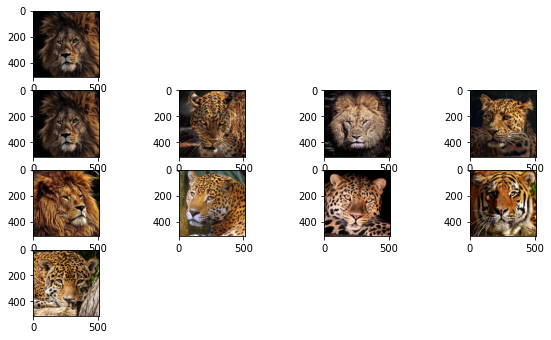

In [ ]:
#Number of query images
N = 9
output = similarImages_N(imagePath, my_model, N)
# output has the list of image ids

## **END**

In [ ]:
id = 8
base_image, similar_images_df = get_similar_images_annoy(id)
name = 'dataset/'+ str(id) + '.jpg'

1.0552406311035156 ms


True Image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


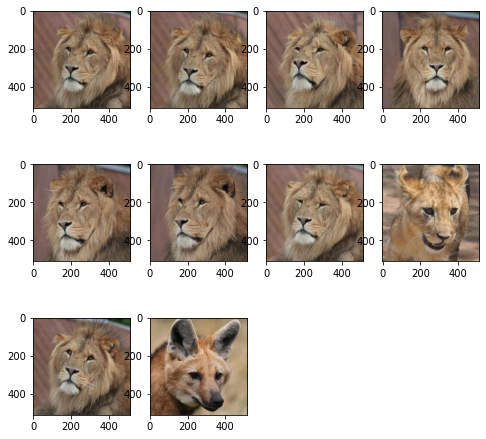

In [ ]:
w=10
h=10
columns = 4
rows = 3
img = cv2.imread(name)
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(rows, columns, 1)
plt.imshow(img_cvt)
print("True Image")
for i, k in enumerate(similar_images_df["image_name"].to_list()):
    name = 'dataset/'+   str(k) + '.jpg'
    img = cv2.imread(name)
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_cvt)
plt.show()

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
feat = np.array(df['features'].tolist())


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4738 samples in 0.070s...
[t-SNE] Computed neighbors for 4738 samples in 0.917s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4738
[t-SNE] Computed conditional probabilities for sample 2000 / 4738
[t-SNE] Computed conditional probabilities for sample 3000 / 4738
[t-SNE] Computed conditional probabilities for sample 4000 / 4738
[t-SNE] Computed conditional probabilities for sample 4738 / 4738
[t-SNE] Mean sigma: 0.018692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.784698
[t-SNE] KL divergence after 1000 iterations: 1.249095


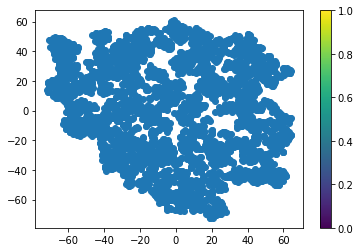

In [ ]:
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feat)
feature_list_compressed = pca.transform(feat)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed
#selected_class_ids = class_ids[:4000]
#selected_filenames = filenames

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean',perplexity=30.0).fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300)

# fitting the k means algorithm on scaled data
kmeans.fit(feat)

In [ ]:
kmeans.inertia_

Text(0, 0.5, 'Inertia')

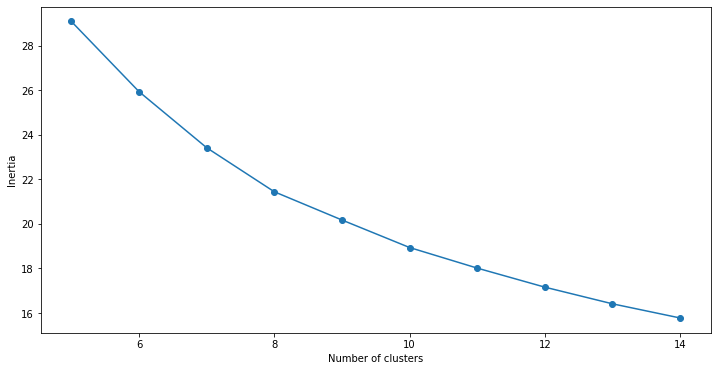

In [ ]:
SSE = []
for cluster in range(5,15):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(feat)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(5,15), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
kmeans = KMeans(n_jobs = -1, n_clusters = 8, init='k-means++')
kmeans.fit(feat)
pred = kmeans.predict(feat)

In [ ]:
frame = pd.DataFrame(feat)
frame['cluster'] = pred
frame['cluster'].value_counts()

5    812
6    713
0    699
7    651
1    637
2    485
4    418
3    323
Name: cluster, dtype: int64

In [ ]:
for i in range(8):
    print("class {}".format(i), frame[frame["cluster"] == i].index[0])

class 0 3
class 1 2
class 2 18
class 3 4
class 4 10
class 5 5
class 6 15
class 7 0


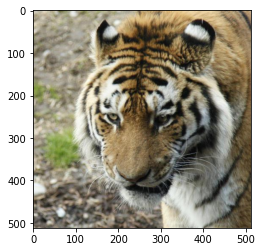

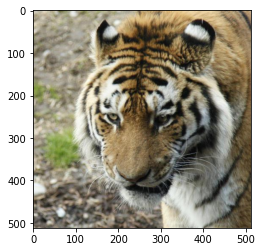

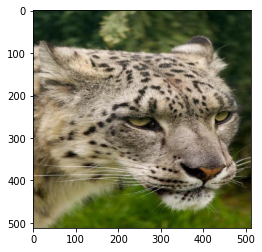

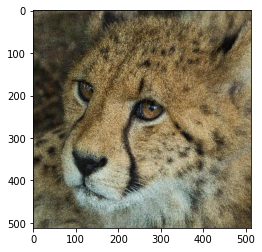

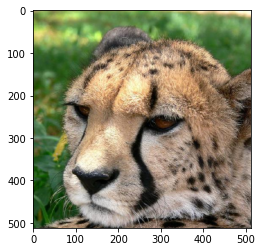

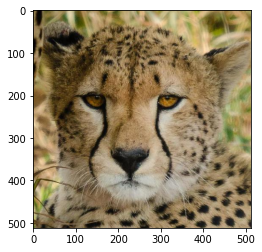

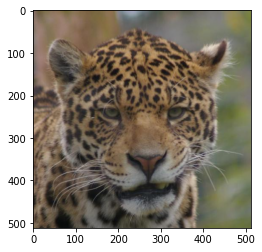

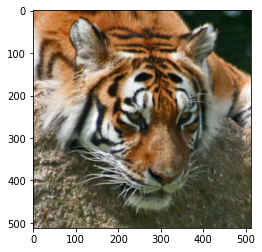

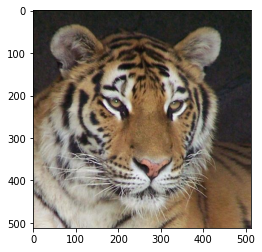

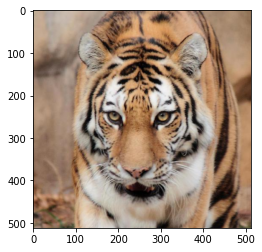

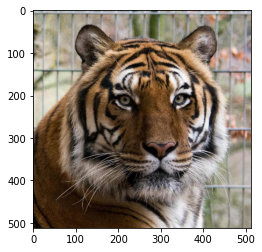

In [ ]:

name = 'dataset/'+str(0) + '.jpg'   
img = cv2.imread(name)
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
for i,_ in frame[frame["cluster"] == 7][:10].iterrows():
    name = 'dataset/'+str(i) + '.jpg'   
    img = cv2.imread(name)
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()